In [1]:
import json
import typing as tp
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
from lessons import *
from metrics import *

In [3]:
annotations = None
with open("../dataset/annotations/annotations.json", "r") as fp:
    annotations = json.load(fp)

In [4]:
def flooding(row, col, sure_bg):
    rows, cols = sure_bg.shape
    sure_bg[row, col] = 0
    Q = [(row, col)]
    while len(Q) > 0:
        y, x = Q.pop()

        for x2 in range(-1, 2):
            for y2 in range(-1, 2):
                if x + x2 < 0 or x + x2 >= cols: continue
                if y + y2 < 0 or y + y2 >= rows: continue

                if sure_bg[y + y2, x + x2] == 255:
                    sure_bg[y + y2, x + x2] = 0
                    Q.append((y + y2, x + x2))

In [5]:
def process_image(path):
    img_name = path.split("/")[-1]
    img_bgr = cv2.imread(path)
    img_bgr = img_bgr[400:, :, :]  # get region of interest
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    # QUESTION: ¿change intensity? ¿luma, value, L from HSL, L from Lab, ...?

    # compute contrast using clahe
    contrast = clahe(img_gray)

    # binarize by threshold
    thresh = binarize_by_thresholding(contrast, 40)

    # get the negative threshold
    thresh_inv = negative(thresh)

    # noise removal
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh_inv.astype('uint8'), cv2.MORPH_OPEN, kernel, iterations=2)

    # sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
    
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # remove border noise
    rows, cols = sure_bg.shape
    for col in range(cols):
        if sure_bg[0, col] == 255:
            flooding(0, col, sure_bg)
        if sure_bg[rows - 1, col] == 255:
            flooding(rows - 1, col, sure_bg)
    for row in range(rows):
        if sure_bg[row, 0] == 255:
            flooding(row, 0, sure_bg)
        if sure_bg[row, cols - 1] == 255:
            flooding(row, cols - 1, sure_bg)

    # find "person" contours
    contours, hierarchy = cv2.findContours(sure_bg ,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # QUESTION ¿apply area threshold min/max?
    # contour_area = cv2.contourArea(contours[0])

    # TN ignored in detection
    # TODO: compute FP
    TP, TN, FP, FN = 0, 0, 0, 0

    if img_name not in annotations.keys():
        return TP, TN, FP, FN
    
    visited = sure_bg.copy()

    for ann in annotations[img_name]:
        x, y = ann
        y -= 400  # sustract the region out of interest

        if sure_bg[y, x] == 255:
            TP += 1
            flooding(y, x, visited)
        else:
            FN += 1

    for row in range(rows):
        for col in range(cols):
            if col < 0 or col >= cols: continue
            if row < 0 or row >= rows: continue

            if visited[row, col] == 255:
                FP += 1
                flooding(row, col, visited)

    return TP, TN, FP, FN

In [29]:
m = pd.DataFrame({}, columns=['filename', 'TP', 'FP', 'FN', 'Precision', 'Recall', 'Accuracy', 'MSE'])
y_real, y_pred = list(), list()

for path in glob("../dataset/images/*.jpg"):
    TP, TN, FP, FN = process_image(path)
    #print("Path: ", TP, TN, FP, FN)
    y_real.append(TP + FN)
    y_pred.append(TP)  # + FP?

    prec = precision(TP, FP)
    rec = recall(TP, FN)
    acc = accuracy(TP, TN, FP, FN)
    mse_score = mse([TP + FN], [TP + FP])

    new_row = pd.DataFrame({
        "filename": path.split("/")[-1], "TP": TP, "FP": FP, "FN": FN,
        "Precision": prec, "Recall": rec, "Accuracy": acc, "MSE": mse_score}, index=[0])
    m = pd.concat([m, new_row], ignore_index=True)

/tmp/ipykernel_6819/3852976005.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  m = pd.concat([m, new_row], ignore_index=True)


In [31]:
m.sort_values('filename')

,filename,TP,FP,FN,Precision,Recall,Accuracy,MSE
6,1660712400.jpg,0,0,0,100.000000,100.000000,100.000000,0.0
4,1660719600.jpg,2,15,10,11.764706,16.666667,7.407407,25.0
0,1660723200.jpg,3,23,35,11.538462,7.894737,4.918033,144.0
7,1660726800.jpg,6,23,118,20.689655,4.838710,4.081633,9025.0
1,1660730400.jpg,10,43,136,18.867925,6.849315,5.291005,8649.0
8,1660734000.jpg,6,57,138,9.523810,4.166667,2.985075,6561.0
9,1660737600.jpg,6,35,140,14.634146,4.109589,3.314917,11025.0
3,1660741200.jpg,7,62,141,10.144928,4.729730,3.333333,6241.0
2,1660748400.jpg,18,61,147,22.784810,10.909091,7.964602,7396.0
5,1660752000.jpg,40,69,128,36.697248,23.809524,16.877637,3481.0


In [32]:
m['MSE'].mean(), m['MSE'].median()

(np.float64(5254.7), np.float64(6401.0))

In [8]:
mses = []

for row in m.sort_values('filename').values:
    _, TP, FP, FN, _, _, _ = row
    item = mse([TP + FN], [TP])
    mses.append(item)
    print(item)

0.0
100.0
1225.0
13924.0
18496.0
19044.0
19600.0
19881.0
21609.0
16384.0


In [9]:
np.median(mses)

np.float64(17440.0)

In [10]:
y_real, y_pred

([38, 146, 165, 148, 12, 168, 0, 124, 144, 146],
 [3, 10, 18, 7, 2, 40, 0, 6, 6, 6])

In [11]:
mse(y_real, y_pred)

13026.3

In [12]:
img_bgr = cv2.imread('../dataset/images/1660752000.jpg')

# get region of interest
img_bgr = img_bgr[400:,:,:]

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

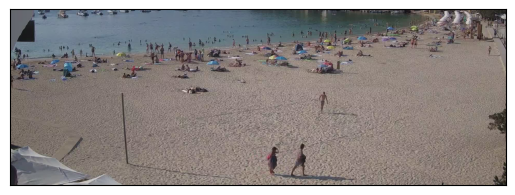

In [13]:
plt.imshow(img_rgb)
plt.xticks([]);
plt.yticks([]);

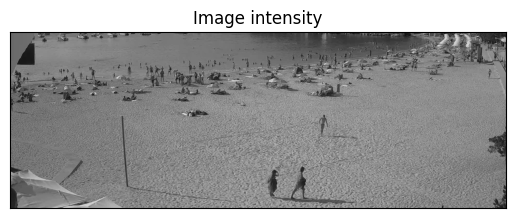

In [14]:
plt.imshow(img_gray, cmap='gray')
plt.xticks([]);
plt.yticks([]);
plt.title('Image intensity');

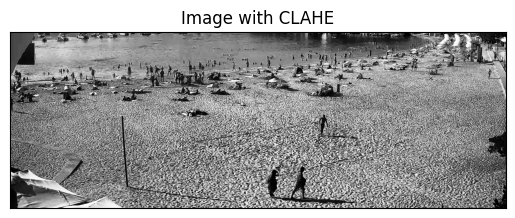

In [15]:
contrast = clahe(img_gray)
plt.imshow(contrast, cmap='gray')
plt.xticks([]);
plt.yticks([]);
plt.title('Image with CLAHE');

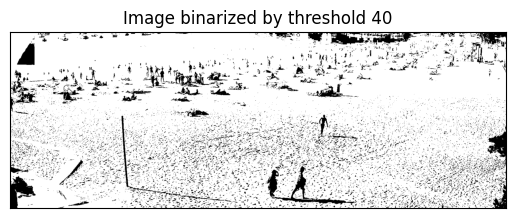

In [16]:
thresh = binarize_by_thresholding(contrast, 40)
plt.imshow(thresh, cmap='gray')
plt.xticks([]);
plt.yticks([]);
plt.title('Image binarized by threshold 40');

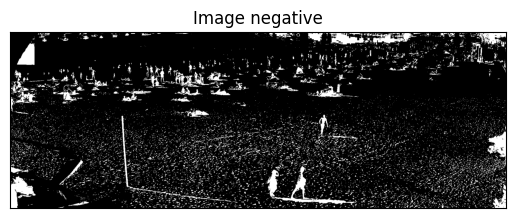

In [17]:
thresh_inv = negative(thresh)
plt.imshow(thresh_inv, cmap='gray')
plt.xticks([]);
plt.yticks([]);
plt.title('Image negative');

In [18]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh_inv.astype('uint8'), cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

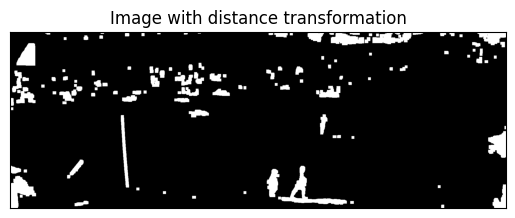

In [19]:
plt.imshow(sure_bg, cmap='gray')
plt.xticks([]);
plt.yticks([]);
plt.title('Image with distance transformation');

In [20]:
rows, cols = sure_bg.shape

for col in range(cols):
    if sure_bg[0, col] == 255:
        flooding(0, col, sure_bg)
    if sure_bg[rows - 1, col] == 255:
        flooding(rows - 1, col, sure_bg)

for row in range(rows):
    if sure_bg[row, 0] == 255:
        flooding(row, 0, sure_bg)
    if sure_bg[row, cols - 1] == 255:
        flooding(row, cols - 1, sure_bg)

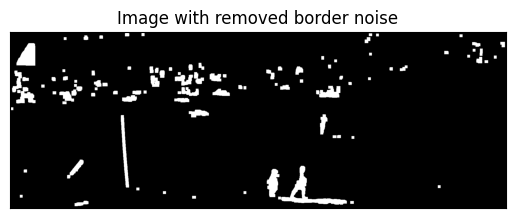

In [21]:
plt.imshow(sure_bg, cmap='gray')

plt.xticks([]);
plt.yticks([]);
plt.title('Image with removed border noise');

In [22]:
contours, hierarchy = cv2.findContours(sure_bg ,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [23]:
len(contours)

101

In [24]:
# filter by min/max area?

In [25]:
contour_area = cv2.contourArea(contours[0])
contour_area

130.0

In [26]:
TP, TN, FP, FN = process_image('../dataset/images/1660752000.jpg')
TP, TN, FP, FN

(40, 0, 69, 128)

In [27]:
img_pred = img_rgb.copy()

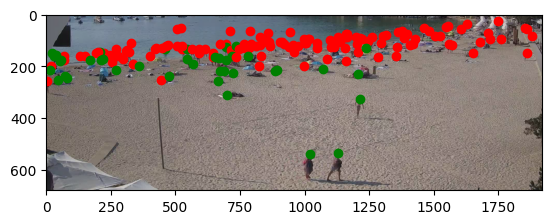

In [28]:
plt.imshow(img_pred)

for ann in annotations['1660752000.jpg']:
    x, y = ann
    y -= 400  # sustract the region out of interest

    if sure_bg[y, x] == 255:
        plt.scatter([x], [y], c='g')

    else:
        plt.scatter([x], [y], c='r')

plt.show()

PATCH_SIZE = 40 # 40

height, width = img_gray.shape

rows = height // PATCH_SIZE
cols = width // PATCH_SIZE

rows, cols

def get_image_patches(image):
    patches = []
    for y in range(0, image.shape[0] - PATCH_SIZE + 1, PATCH_SIZE):
        for x in range(0, image.shape[1] - PATCH_SIZE + 1, PATCH_SIZE):
            patches.append(image[y:y + PATCH_SIZE, x:x + PATCH_SIZE])
    return patches

patches = get_image_patches(img_gray)

len(patches)

MIN_COUNT = 100

def count_persons_from_patch(patch, plot=False):
    img = binarize_by_otsu(negative(patch))
    count = 0

    while img.any():
        largest_object_img = largest_object(img)
        img = np.logical_and(img, negative(largest_object_img))

        if largest_object_img.sum() // 255 > MIN_COUNT:
            if plot:
                plt.imshow(largest_object_img, cmap='gray')
                plt.show()
            count += 1

    return count

persons_per_patch = [count_persons_from_patch(patch) for patch in patches]

sum(persons_per_patch)

matrix = np.array(persons_per_patch).reshape((rows, cols))

sns.heatmap(matrix)